# Spark Funds Investment Analysis

### Data Preparation

In [724]:
# loading libraries

import numpy as np
import pandas as pd

# read data
companies_df=pd.read_csv("https://cdn.upgrad.com/UpGrad/temp/d934844e-5182-4b58-b896-4ba2a499aa57/companies.txt", sep="\t", encoding='palmos')
rounds2_df = pd.read_csv("/Users/nagendrapalla/Sunanda/ML and AI/Statistics Essential/Investment analysis case study/rounds2.csv", encoding ='palmos')
mapping_df = pd.read_csv("/Users/nagendrapalla/Sunanda/ML and AI/Statistics Essential/Investment analysis case study/mapping.csv", encoding ='palmos')


In [725]:
#converting company links in rounds2 and companies to lowercase
rounds2_df['company_permalink'] = rounds2_df['company_permalink'].str.lower()
companies_df['permalink'] = companies_df['permalink'].str.lower()

#converting category list in companies and mapping to lowercase
companies_df['category_list'] = companies_df['category_list'].str.lower()
mapping_df['category_list'] = mapping_df['category_list'].str.lower()

In [726]:
#Unique companies present in rounds2
rounds2_df['company_permalink'].describe()

count                       114949
unique                       66368
top       /organization/solarflare
freq                            19
Name: company_permalink, dtype: object

In [727]:
#Unique companies present in companies
companies_df['permalink'].describe()

count                    66368
unique                   66368
top       /organization/3touch
freq                         1
Name: permalink, dtype: object

In [728]:
#Are there any companies in the rounds2 file which are not present in companies? Answer yes or no: Y/N
#Merge the two data frames so that all variables (columns) in the companies frame are added to the rounds2 data frame. Name the merged frame master_frame. How many observations are present in master_frame?
master_frame=pd.merge(companies_df,rounds2_df,how='inner',right_on='company_permalink',left_on='permalink')

In [729]:
master_frame['company_permalink'].describe()

count                       114949
unique                       66368
top       /organization/solarflare
freq                            19
Name: company_permalink, dtype: object

In [730]:
master_frame['permalink'].describe()

count                       114949
unique                       66368
top       /organization/solarflare
freq                            19
Name: permalink, dtype: object

##### Since the unique items above are same, there is no company that is present in rounds2 and not present in companies

### Data Cleaning

In [731]:
# first row of the mapping dataset is empty. Hence, dropping the first row
mapping_df=mapping_df.drop(mapping_df.index[0])

# Replacing : certain values in the category_list column has '0' instead of 'na'
#(Ex:Instead of 'Analytics', mapping dataset has 'A0lytics')
mapping_df['category_list']=mapping_df['category_list'].str.replace('0','na')

# replacing 'enterprise 2.na' with 'enterprise 2.0' which was changed during the previous step
mapping_df['category_list']=mapping_df['category_list'].str.replace('enterprise 2.na','enterprise 2.0')

In [732]:
#Checking for NaN values in the column 'raised_amount_usd'
#No. of rows with NA in 'raised_amount_usd'
master_frame.raised_amount_usd.isna().sum()

19990

In [733]:
#replacing NA with '0'
master_frame['raised_amount_usd']=master_frame['raised_amount_usd'].fillna(0)
#Checking for NA post null value treatment
master_frame.raised_amount_usd.isna().sum()

0

### Investment type Analysis

In [734]:
#calculating average investment amopunt by investment type
avg_investment_type=master_frame.groupby(["funding_round_type"])['raised_amount_usd'].aggregate(np.mean).reset_index().sort_values('raised_amount_usd')

In [735]:
#Converting units of the aggregate/'mean' column to million
avg_investment_type['raised_amount_usd']=avg_investment_type['raised_amount_usd']/1000000

In [736]:
#Identifying Investment type between 5million to 15million USD
#suitable investment type for Spark Funds
avg_investment_type.loc[(avg_investment_type.raised_amount_usd>=5)&(avg_investment_type.raised_amount_usd<=15)]

,funding_round_type,raised_amount_usd
12,undisclosed,6.216343
13,venture,10.634054


##### 'Venture' is the most suitable investment type

### Country Analysis

In [737]:
#Filter for 'venture' investment type and create dataframe named master_frame_venture
funding_round = ['venture']
master_frame_venture= master_frame[master_frame.funding_round_type.isin(funding_round)]

In [738]:
#Total investment amount by country
top_investment_country=master_frame_venture.groupby(["country_code"])['raised_amount_usd'].aggregate(np.sum).reset_index().sort_values('raised_amount_usd')
#Converting units of the aggregate/'sum' column to billion
top_investment_country['raised_amount_usd']=top_investment_country['raised_amount_usd']/1000000000

In [739]:
#Nine countries with highest investment amount(top 9)
top9=top_investment_country.sort_values('raised_amount_usd',ascending=False).head(9).reset_index()
top9=top9[['country_code','raised_amount_usd']].copy()

In [740]:
top9.head(5)

,country_code,raised_amount_usd
0,USA,422.510843
1,CHN,39.835419
2,GBR,20.245627
3,IND,14.391859
4,CAN,9.583332


##### Top english speaking countries from the list provided and the above investment amount

USA(United States of America), GBR(United Kingdom), IND(India) respectively

### Sector Analysis

#### Data preparation for sector analysis

In [741]:
#identify the primary sector and create a new column from the category_list value
master_frame_venture['primary_category']=master_frame_venture['category_list'].str.split("|").str.get(0)

#Merge master_frame_venture and mapping dataframes to obtain the main sector flags from mapping dataframe 
master_frame_final=pd.merge(master_frame_venture,mapping_df,how='left',left_on='primary_category',right_on='category_list')


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [742]:
#Create a function to identify the main sector for each primary sector
def f(row):
    if row['Automotive & Sports'] == 1:
        val = 'Automotive & Sports'
    elif row['Cleantech / Semiconductors'] == 1:
        val = 'Cleantech / Semiconductors'
    elif row['Entertainment'] == 1:
        val = 'Entertainment'
    elif row['Health'] == 1:
        val = 'Health'
    elif row['Manufacturing'] == 1:
        val = 'Manufacturing'
    elif row['News, Search and Messaging'] == 1:
        val = 'News, Search and Messaging'
    elif row['Others'] == 1:
        val = 'Others'   
    elif row['Social, Finance, Analytics, Advertising'] == 1:    
        val = 'Social, Finance, Analytics, Advertising'
    elif row['Blanks'] == 1:
        val = 'Blanks'
    else:
        val = 'None'
    return val

In [743]:
#apply the function created in the previous step and create a column main_sector for each row
master_frame_final['main_sector'] = master_frame_final.apply(f, axis=1)

#select only the relevant columns by dropping main sector flag columns
master_frame_df = master_frame_final[['permalink','name','homepage_url','category_list_x','status','country_code','state_code','region','city','founded_at','company_permalink','funding_round_permalink','funding_round_type','funding_round_code','funded_at','raised_amount_usd','primary_category','main_sector']].copy()


In [744]:
#rename column to appropriate column name
master_frame_df.rename(columns={'category_list_x':'category_list'})

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,primary_category,main_sector
0,/organization/-fame,#fame,http://livfame.com,media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0,media,Entertainment
1,/organization/-qounter,:Qounter,http://www.qounter.com,application platforms|real time|social network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,0.0,application platforms,"News, Search and Messaging"
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,apps|games|mobile,operating,NaN,NaN,NaN,NaN,NaN,/organization/-the-one-of-them-inc-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.0,apps,"News, Search and Messaging"
3,/organization/0-6-com,0-6.com,http://www.0-6.com,curated web,operating,CHN,22,Beijing,Beijing,01-01-2007,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0,curated web,"News, Search and Messaging"
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010,/organization/004-technologies,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,24-07-2014,0.0,software,Others
5,/organization/0ndine-biomedical-inc,Ondine Biomedical Inc.,http://ondinebio.com,biotechnology,operating,CAN,BC,Vancouver,Vancouver,01-01-1997,/organization/0ndine-biomedical-inc,/funding-round/954b9499724b946ad8c396a57a5f3b72,venture,NaN,21-12-2009,719491.0,biotechnology,Cleantech / Semiconductors
6,/organization/0xdata,H2O.ai,http://h2o.ai/,analytics,operating,USA,CA,SF Bay Area,Mountain View,01-01-2011,/organization/0xdata,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,09-11-2015,20000000.0,analytics,"Social, Finance, Analytics, Advertising"
7,/organization/0xdata,H2O.ai,http://h2o.ai/,analytics,operating,USA,CA,SF Bay Area,Mountain View,01-01-2011,/organization/0xdata,/funding-round/ae2a174c06517c2394aed45006322a7e,venture,NaN,03-01-2013,1700000.0,analytics,"Social, Finance, Analytics, Advertising"
8,/organization/0xdata,H2O.ai,http://h2o.ai/,analytics,operating,USA,CA,SF Bay Area,Mountain View,01-01-2011,/organization/0xdata,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,venture,A,19-07-2014,8900000.0,analytics,"Social, Finance, Analytics, Advertising"
9,/organization/1-mainstream,1 Mainstream,http://www.1mainstream.com,apps|cable|distribution|software,acquired,USA,CA,SF Bay Area,Cupertino,01-03-2012,/organization/1-mainstream,/funding-round/b952cbaf401f310927430c97b68162ea,venture,NaN,17-03-2015,5000000.0,apps,"News, Search and Messaging"


In [745]:
#filter for investments made in USA and create a dataframe master_frame_d1
country = ['USA']
master_frame_d1= master_frame_df[master_frame_df.country_code.isin(country)]
#filter for 5million to 15million investments in USA
d1=master_frame_d1.loc[(master_frame_d1.raised_amount_usd>=5000000)&(master_frame_d1.raised_amount_usd<=15000000)]
#Converting units of the raised_amount_usd column to millions USD
d1['raised_amount_usd']=d1['raised_amount_usd']/1000000

#filter for investments made in United Kingdom and create a dataframe master_frame_d1
country = ['GBR']
master_frame_d2= master_frame_df[master_frame_df.country_code.isin(country)]
#filter for 5million to 15million investments in GBR
d2=master_frame_d2.loc[(master_frame_d2.raised_amount_usd>=5000000)&(master_frame_d2.raised_amount_usd<=15000000)]
#Converting units of the raised_amount_usd column to millions USD
d2['raised_amount_usd']=d2['raised_amount_usd']/1000000

#filter for investments made in India and create a dataframe master_frame_d1
country = ['IND']
master_frame_d3= master_frame_df[master_frame_df.country_code.isin(country)]
#filter for 5million to 15million investments in IND
d3=master_frame_d3.loc[(master_frame_d3.raised_amount_usd>=5000000)&(master_frame_d3.raised_amount_usd<=15000000)]
#Converting units of the raised_amount_usd column to millions USD
d3['raised_amount_usd']=d3['raised_amount_usd']/1000000


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.or

##### Total investments and investment amount by top countries

In [759]:
#USA
d1.groupby('country_code')['raised_amount_usd'].agg(['count','sum'])

,count,sum
country_code,,
USA,12150,108531.347515


In [760]:
#GBR
d2.groupby('country_code')['raised_amount_usd'].agg(['count','sum'])

,count,sum
country_code,,
GBR,628,5436.843539


In [761]:
#IND
d3.groupby('country_code')['raised_amount_usd'].agg(['count','sum'])

,count,sum
country_code,,
IND,330,2976.543602


##### Total investments and average investment amount across sectors for top countries

In [762]:
#USA

d1_sector=d1.groupby('main_sector')['raised_amount_usd'].agg(['count','mean']).sort_values('count',ascending=False).reset_index()
#rename the aggregate columns for better readability
d1_sector.rename(columns={'count': 'inv_count','mean': 'avg_inv'}, inplace=True)
d1_sector.head()

,main_sector,inv_count,avg_inv
0,Others,2950,8.922375
1,"Social, Finance, Analytics, Advertising",2714,8.772062
2,Cleantech / Semiconductors,2350,9.205715
3,"News, Search and Messaging",1583,8.826006
4,Health,909,9.033949


In [763]:
#GBR

d2_sector=d2.groupby('main_sector')['raised_amount_usd'].agg(['count','mean']).sort_values('count',ascending=False).reset_index()
#rename the aggregate columns for better readability
d2_sector.rename(columns={'count': 'inv_count','mean': 'avg_inv'}, inplace=True)
d2_sector.head()

,main_sector,inv_count,avg_inv
0,Others,147,8.732138
1,"Social, Finance, Analytics, Advertising",133,8.191008
2,Cleantech / Semiconductors,130,8.953770
3,"News, Search and Messaging",73,8.434880
4,Entertainment,56,8.621155


In [764]:
#IND

d3_sector=d3.groupby('main_sector')['raised_amount_usd'].agg(['count','mean']).sort_values('count',ascending=False).reset_index()
#rename the aggregate columns for better readability
d3_sector.rename(columns={'count': 'inv_count','mean': 'avg_inv'}, inplace=True)
d3_sector.head()

,main_sector,inv_count,avg_inv
0,Others,110,9.212814
1,"Social, Finance, Analytics, Advertising",60,9.175826
2,"News, Search and Messaging",52,8.342972
3,Entertainment,33,8.510000
4,Manufacturing,21,9.566667


##### Top performing companies among the top sectors in each country

In [765]:
#USA
#Best performing companies in the best sector 'Social, Finance, Analytics, Advertising'

#Filter for the best sector
sector1_d1 = ['Social, Finance, Analytics, Advertising']
d1_sec1_filter= d1[d1.main_sector.isin(sector1_d1)]

d1_company1=d1_sec1_filter.groupby('name')['raised_amount_usd'].agg(['count','sum']).sort_values('sum',ascending=False).reset_index()
d1_company1.head(2)

,name,count,sum
0,SST Inc. (Formerly ShotSpotter),7,67.933006
1,Demandbase,5,63.000000


In [766]:
#USA
#Best performing companies in the second best sector 'Cleantech / Semiconductors'

#Filter for the second best sector
sector2_d1 = ['Cleantech / Semiconductors']
d1_sec2_filter= d1[d1.main_sector.isin(sector2_d1)]

d1_company2=d1_sec2_filter.groupby('name')['raised_amount_usd'].agg(['count','sum']).sort_values('sum',ascending=False).reset_index()
d1_company2.head(2)

,name,count,sum
0,Biodesix,8,75.300000
1,Tigo Energy,8,68.739496


In [767]:
#GBR
#Best performing companies in the best sector 'Social, Finance, Analytics, Advertising'

#Filter for the best sector
sector1_d2 = ['Social, Finance, Analytics, Advertising']
d2_sec1_filter= d2[d2.main_sector.isin(sector1_d2)]

d2_company1=d2_sec1_filter.groupby('name')['raised_amount_usd'].agg(['count','sum']).sort_values('sum',ascending=False).reset_index()
d2_company1.head(2)

,name,count,sum
0,Celltick Technologies,4,37.5
1,myThings,4,34.0


In [768]:
#GBR
#Best performing companies in the second best sector 'Cleantech / Semiconductors'

#Filter for the second best sector
sector2_d2 = ['Cleantech / Semiconductors']
d2_sec2_filter= d2[d2.main_sector.isin(sector2_d2)]

d2_company2=d2_sec2_filter.groupby('name')['raised_amount_usd'].agg(['count','sum']).sort_values('sum',ascending=False).reset_index()
d2_company2.head(2)

,name,count,sum
0,EUSA Pharma,3,35.600000
1,Horizon Discovery,3,31.353719


In [769]:
#IND
#Best performing companies in the best sector 'Social, Finance, Analytics, Advertising'

#Filter for the best sector
sector1_d3 = ['Social, Finance, Analytics, Advertising']
d3_sec1_filter= d3[d3.main_sector.isin(sector1_d3)]

d3_company1=d3_sec1_filter.groupby('name')['raised_amount_usd'].agg(['count','sum']).sort_values('sum',ascending=False).reset_index()
d3_company1.head(2)

,name,count,sum
0,Manthan Systems,4,50.7
1,Komli Media,3,28.0


In [770]:
#IND
#Best performing companies in the second best sector 'News, Search and Messaging'

#Filter for the second best sector
sector2_d3 = ['News, Search and Messaging']
d3_sec2_filter= d3[d3.main_sector.isin(sector2_d3)]

d3_company2=d3_sec2_filter.groupby('name')['raised_amount_usd'].agg(['count','sum']).sort_values('sum',ascending=False).reset_index()
d3_company2.head(2)

,name,count,sum
0,GupShup,3,33.0
1,IMImobile,2,23.0


#### Plots

#### Average investment funding by investment type

In [771]:
#Filter for the required investment types
invest_type = ['private_equity','seed','venture','angel','grant']
plot1_df= avg_investment_type_1[avg_investment_type_1.funding_round_type.isin(invest_type)]

#dataframe to sort the values in the plot
result1=plot1_df.groupby(["funding_round_type"])['raised_amount_usd'].aggregate(np.mean).reset_index().sort_values('raised_amount_usd')

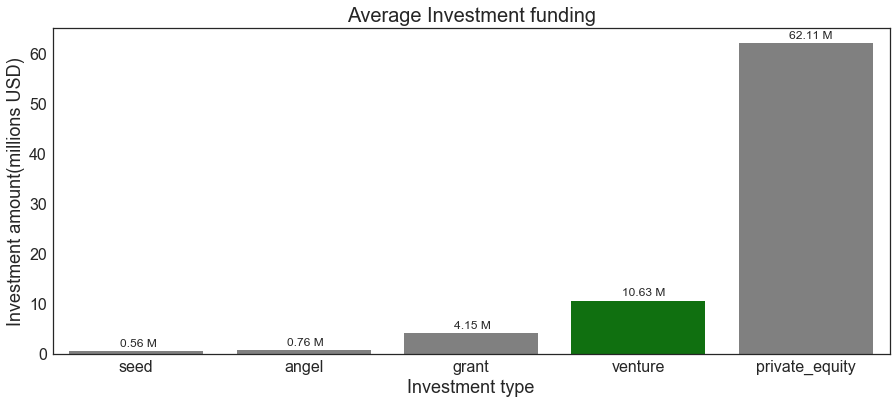

In [772]:
#read libraries to create plots
import matplotlib.pyplot as plt
import seaborn as sns

# set background to white
sns.set(style="white")
#set fontsize of the axislabels
sns.set_context("paper", font_scale=2)
#set figure size
plt.figure(figsize=(15, 6))

#Color code to highlight the best investment type for spark funds
clrs = ['green' if ((y <= 15) & (y >= 5)) else 'grey' for y in plot1_df.raised_amount_usd]
#Plot investment type vs average investment amount
ax=sns.barplot(x='funding_round_type', y='raised_amount_usd', data=plot1_df, order=result1['funding_round_type'], palette=clrs)

#Display value of the bars in millions USD
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.3, i.get_height()+1, str(round((i.get_height()), 2))+' M', fontsize=12)

#set plot title,axeslabels
plt.title("Average Investment funding", fontsize=20)
plt.xlabel("Investment type", fontsize=18)
plt.ylabel("Investment amount(millions USD)", fontsize=18)
plt.show()

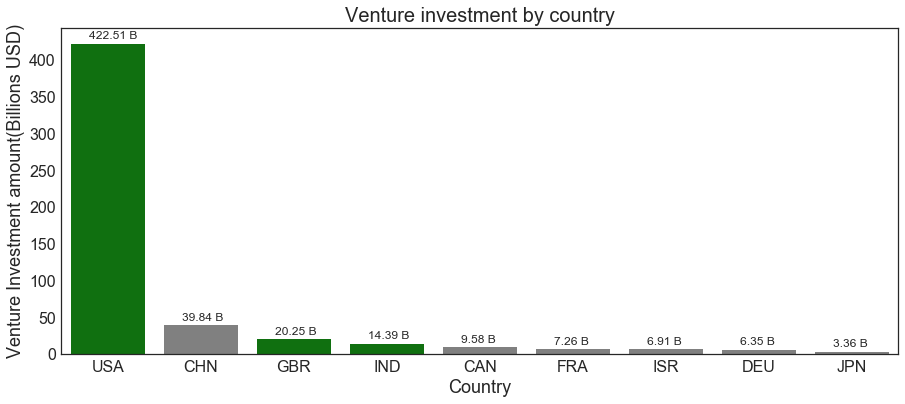

In [773]:
#read libraries to create plots
import matplotlib.pyplot as plt
import seaborn as sns

# set background to white
sns.set(style="white")
#set fontsize of the axislabels
sns.set_context("paper", font_scale=2)
#set figure size
plt.figure(figsize=(15, 6))

#Color code to highlight the best investment type for spark funds
clrs = ['green' if (x in ('USA','GBR','IND')) else 'grey' for x in top9.country_code]
#Plot to understand venture investment by country
ax=sns.barplot(x='country_code', y='raised_amount_usd', estimator=sum, data=top9, palette=clrs)

#Display value of the bars in billions USD
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.2, i.get_height()+6, str(round((i.get_height()), 2))+' B', fontsize=12)
    
#set plot title,axeslabels
plt.title("Venture investment by country", fontsize=20)
plt.xlabel("Country", fontsize=18)
plt.ylabel("Venture Investment amount(Billions USD)", fontsize=18)
plt.show()

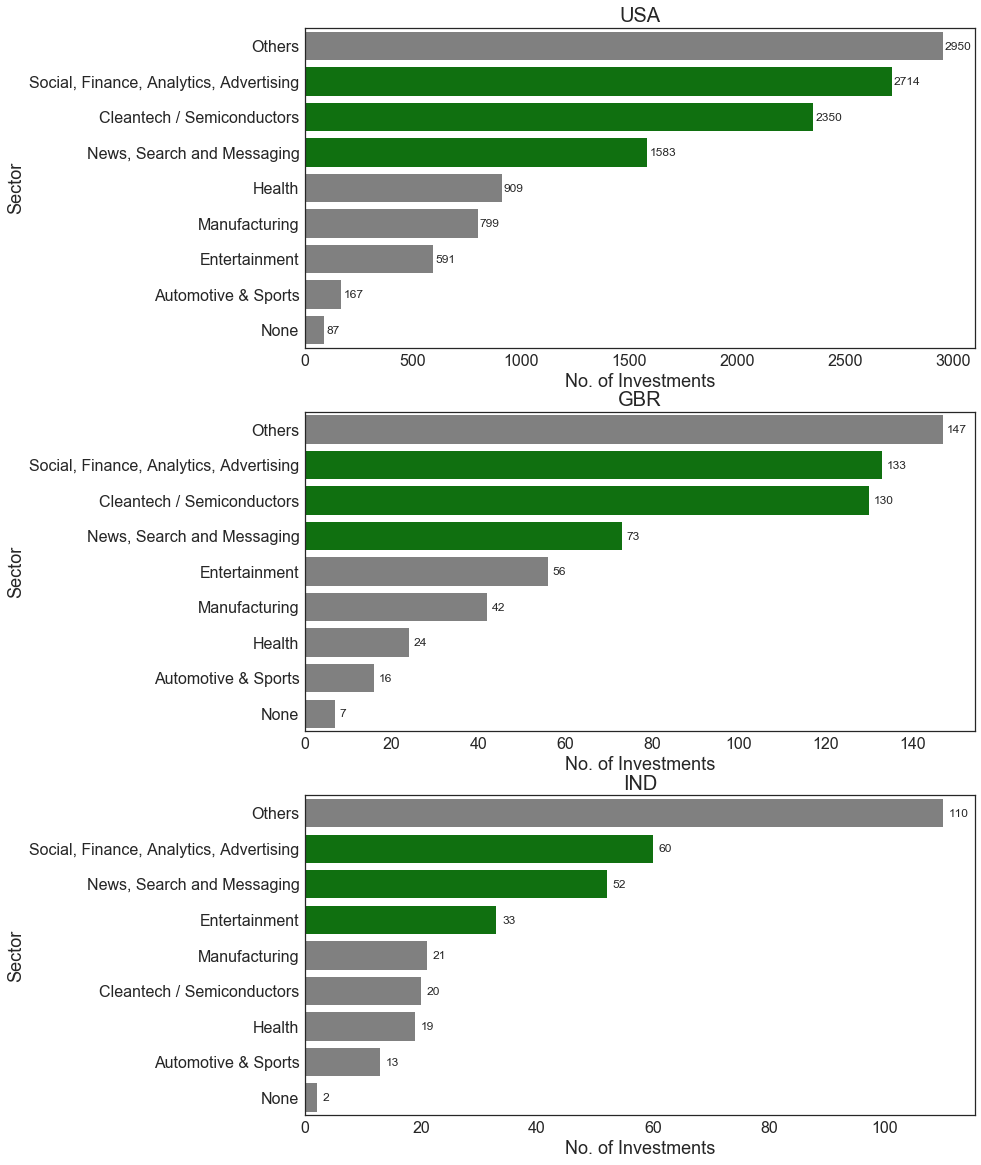

In [774]:
#read libraries to create plots
import matplotlib.pyplot as plt
import seaborn as sns

# set background to white
sns.set(style="white")
#set fontsize of the axislabels
sns.set_context("paper", font_scale=2)

# increase/set figure size 
plt.figure(figsize=(12, 20))
plt.tight_layout()

# subplot 1: USA
plt.subplot(3, 1, 1)
#Color code to highlight the best investment type for spark funds
clrs1 = ['green' if ((x >1500) & (x<2950)) else 'grey' for x in d1_sector.inv_count]
#Plot to understand no. of investments by sector in USA
#master_frame.country_code.value_counts().iloc[:10].index
ax1=sns.barplot(y='main_sector', x='inv_count', data=d1_sector, palette=clrs1)

#Display value of the bars
for i in ax1.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax1.text(i.get_width()+10, i.get_y()+.5,str(int((i.get_width()))), fontsize=12)

#set plot title,axeslabels    
plt.title("USA", fontsize=20)
plt.xlabel("No. of Investments", fontsize=18)
plt.ylabel("Sector", fontsize=18)


# subplot 2: GBR
plt.subplot(3, 1, 2)
#Color code to highlight the best investment type for spark funds
clrs2 = ['green' if ((x >70) & (x<147)) else 'grey' for x in d2_sector.inv_count]
#Plot to understand no. of investments by sector in GBR
ax2=sns.barplot(y='main_sector', x='inv_count', data=d2_sector,palette=clrs2)

#Display value of the bars in millions USD
for i in ax2.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax2.text(i.get_width()+1, i.get_y()+.5,str(int((i.get_width()))), fontsize=12)

#set plot title,axeslabels    
plt.title("GBR", fontsize=20)
plt.xlabel("No. of Investments", fontsize=18)
plt.ylabel("Sector", fontsize=18)

# subplot 3: IND
plt.subplot(3, 1, 3)
#Color code to highlight the best investment type for spark funds
clrs3 = ['green' if ((x >30) & (x<110)) else 'grey' for x in d3_sector.inv_count]
#Plot to understand no. of investments by sector in IND
ax3=sns.barplot(y='main_sector', x='inv_count', data=d3_sector, palette=clrs3)

#Display value of the bars in millions USD
for i in ax3.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax3.text(i.get_width()+1, i.get_y()+.5,str(int((i.get_width()))), fontsize=12)

#set plot title,axeslabels    
plt.title("IND", fontsize=20)
plt.xlabel("No. of Investments", fontsize=18)
plt.ylabel("Sector", fontsize=18)

plt.show()

##### 'Social, Finance, Analytics, Advertising' is the best sector with higher venture investments among top countries